##Importações

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

##Dados Carregados

In [4]:
treino = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')
validacao = pd.read_csv('validation.csv')
print(f'''Informações de teste:
          Formato: {teste.shape}''')
print(f'''Informações de treino:
          Formato: {treino.shape}''')
print(f'''Informações de validacao:
          Formato: {validacao.shape}''')

Informações de teste:
          Formato: (7327, 15)
Informações de treino:
          Formato: (34189, 15)
Informações de validacao:
          Formato: (7326, 15)


##Visualização dos Dados

In [5]:
print(treino.head())

   age workclass  fnlwgt  education  educational-num      marital-status  \
0   25   Private  188767    HS-grad                9       Never-married   
1   64   Private  286732    HS-grad                9             Widowed   
2   29   Private  253801    HS-grad                9  Married-civ-spouse   
3   28   Private  334032  Assoc-voc               11  Married-civ-spouse   
4   22   Private  173004    HS-grad                9       Never-married   

          occupation    relationship   race  gender  capital-gain  \
0       Craft-repair       Own-child  White    Male             0   
1              Sales   Not-in-family  White  Female             0   
2       Craft-repair         Husband  White    Male             0   
3       Craft-repair         Husband  White    Male             0   
4  Machine-op-inspct  Other-relative  Black    Male             0   

   capital-loss  hours-per-week native-country income  
0             0              40  United-States  <=50K  
1             0 

In [6]:
#Verificação do tipo de informação em cada coluna, em como se há algum valor NaN no dataframe
print(treino.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34189 entries, 0 to 34188
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              34189 non-null  int64 
 1   workclass        34189 non-null  object
 2   fnlwgt           34189 non-null  int64 
 3   education        34189 non-null  object
 4   educational-num  34189 non-null  int64 
 5   marital-status   34189 non-null  object
 6   occupation       34189 non-null  object
 7   relationship     34189 non-null  object
 8   race             34189 non-null  object
 9   gender           34189 non-null  object
 10  capital-gain     34189 non-null  int64 
 11  capital-loss     34189 non-null  int64 
 12  hours-per-week   34189 non-null  int64 
 13  native-country   34189 non-null  object
 14  income           34189 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.9+ MB
None


Criacao da função para visualizar os dados

In [7]:
def mostra_dados(tipo):
  if(tipo == 'float'):
    for col in treino.columns:
      if treino[col].dtype in (np.float64, np.int64): # Corrigido aqui para verificar float64 e int64
        #Calcula os limites dos dados e a média deles, e mostra no gráfico
        texto = f''' Menor valor: {treino[col].min()}
                    Maior valor: {treino[col].max()}
                    Média: {treino[col].mean()}'''

        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(treino[col], kde=True, ax=ax)          # Cria o histograma com KDE para suavizar a distribuição
        ax.set_title(f'Distribuição {col}', fontsize=16)    # Define o título do histograma
        ax.set_xlabel(col, fontsize=12)                     # Rótulo do eixo X
        ax.set_ylabel('Frequência', fontsize=12)            # Rótulo do eixo Y
        ax.grid(axis='y', alpha=0.75)                       # Adiciona uma grade no eixo Y

        # Adicionar texto na parte superior direita da figura, de forma relativa
        fig.text(0.9, 0.96, texto, fontsize=10, color='blue', ha='right', va='top', transform=fig.transFigure)
        plt.show()

  else:
    # Iterando pelas colunas e mostrando a contagem de valores para colunas não numéricas
    for col in treino.columns:
        if treino[col].dtype == 'object':
            print(f"\nInformações da coluna '{col}':")
            print(treino[col].value_counts())

#Funcao de conformacao do dataset
Criação de funcao que prepara qualquer dataset para entrar no modelo

In [8]:
scaler = MinMaxScaler()
labelencoder = LabelEncoder()
encoder = OneHotEncoder(sparse_output=False)

def padronizar_dataset(dataset):
  # passa qualquer coluna com dtype int para float
  for col in dataset.columns:
    if dataset[col].dtype == np.int64:
      dataset[col] = dataset[col].astype(float)

  #binning no dataset
  dataset.loc[dataset['workclass'].isin(['?','Without-pay','Never-worked']), 'workclass']                                             = 'Other'
  dataset.loc[dataset['marital-status'].isin(['Married-spouse-absent','Married-AF-spouse','Widowed','Separated']), 'marital-status']  = 'Other'
  dataset.loc[dataset['occupation'].isin(['?','Priv-house-serv','Armed-Forces']), 'occupation']                                       = 'Other'
  dataset.loc[~dataset['native-country'].isin(['United-States']), 'native-country']                                                   = 'Other'
  dataset.loc[~dataset['race'].isin(['White','Black']), 'race']                                                                       = 'Other'
  dataset.loc[dataset['education'].isin(['Preschool','1st-4th','5th-6th','7th-8th','9th']), 'education']                             = 'Basic_School'
  dataset.loc[dataset['education'].isin(['10th','11th','12th']), 'education']                                                        = 'Upper_School'

  categorize_hours_per_week(dataset)

  # Resetar o índice antes de qualquer operação que possa depender de um RangeIndex
  dataset = dataset.reset_index(drop=True)

  for col in dataset.columns:
  # cria a escala para as colunas numericas
    if dataset[col].dtype == np.float64:
      dataset[col] = scaler.fit_transform(dataset[[col]])

  # conforma as colunas com tipo de objeto, faz o Label Encoder delas
    elif (dataset[col].dtype == 'object' and col not in ['race','native-country']):
      dataset[col] = labelencoder.fit_transform(dataset[col])

  #One Hot Encoder no resto das colunas
  encoded_features = encoder.fit_transform(dataset[['native-country', 'race']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['native-country', 'race']))

  dataset = pd.concat([dataset, encoded_df], axis=1)
  # dataset = dataset.drop(columns=['native-country', 'race','native-country_Other','race_Other','capital-gain','capital-loss'])
  dataset = dataset.drop(columns=['native-country', 'race','native-country_Other','race_Other'])
  #Dataset conformado

  return dataset

def categorize_hours_per_week(df):
    conditions = [
        df['hours-per-week'] < 40,
        df['hours-per-week'] == 40,
        df['hours-per-week'] > 40
    ]
    choices = ['<40', '40', '>40']
    df['hours-per-week'] = np.select(conditions, choices, default=df['hours-per-week'])
    return df

#Análise dos dados de treino
Redução de dimensionalidade das colunas de String (Binning)

In [9]:
for col in treino.columns:
  if treino[col].dtype == np.int64:
    treino[col] = treino[col].astype(float)

In [10]:
mostra_dados('object')


Informações da coluna 'workclass':
workclass
Private             23719
Self-emp-not-inc     2687
Local-gov            2194
?                    1969
State-gov            1389
Self-emp-inc         1197
Federal-gov          1009
Without-pay            17
Never-worked            8
Name: count, dtype: int64

Informações da coluna 'education':
education
HS-grad         11018
Some-college     7662
Bachelors        5622
Masters          1875
Assoc-voc        1441
11th             1271
Assoc-acdm       1104
10th              962
7th-8th           663
Prof-school       580
9th               509
12th              461
Doctorate         417
5th-6th           365
1st-4th           179
Preschool          60
Name: count, dtype: int64

Informações da coluna 'marital-status':
marital-status
Married-civ-spouse       15802
Never-married            11156
Divorced                  4625
Widowed                   1071
Separated                 1065
Married-spouse-absent      445
Married-AF-spouse           

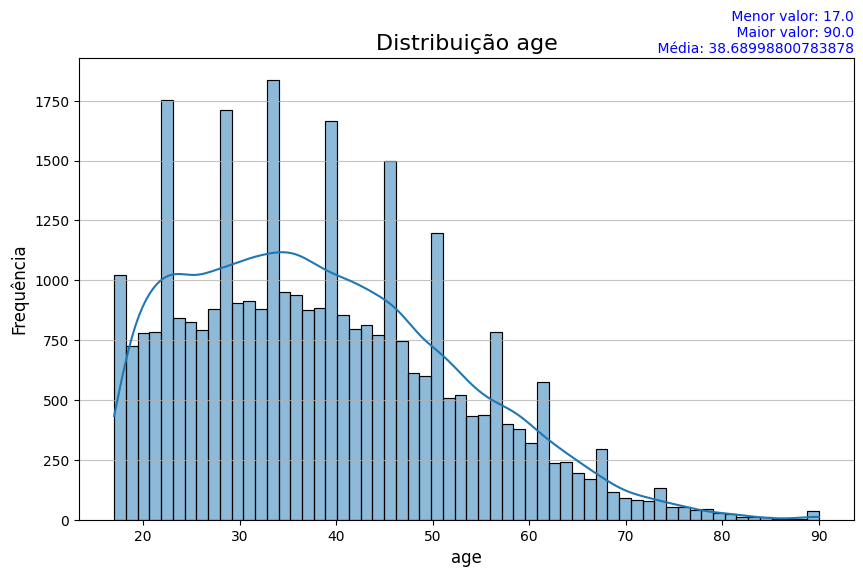

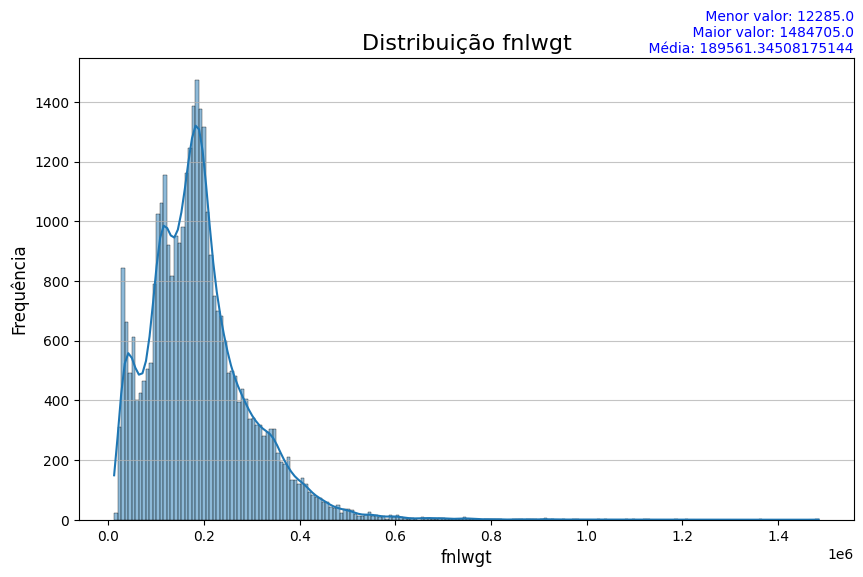

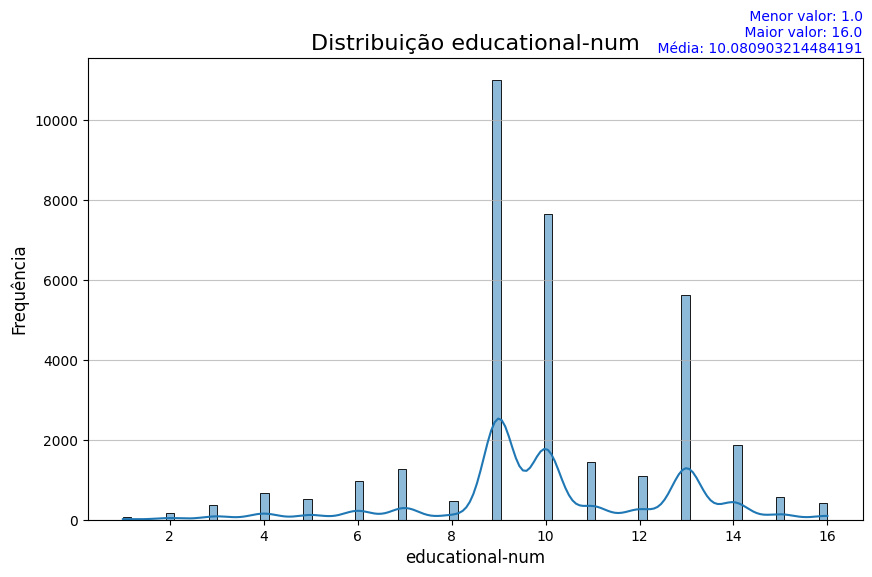

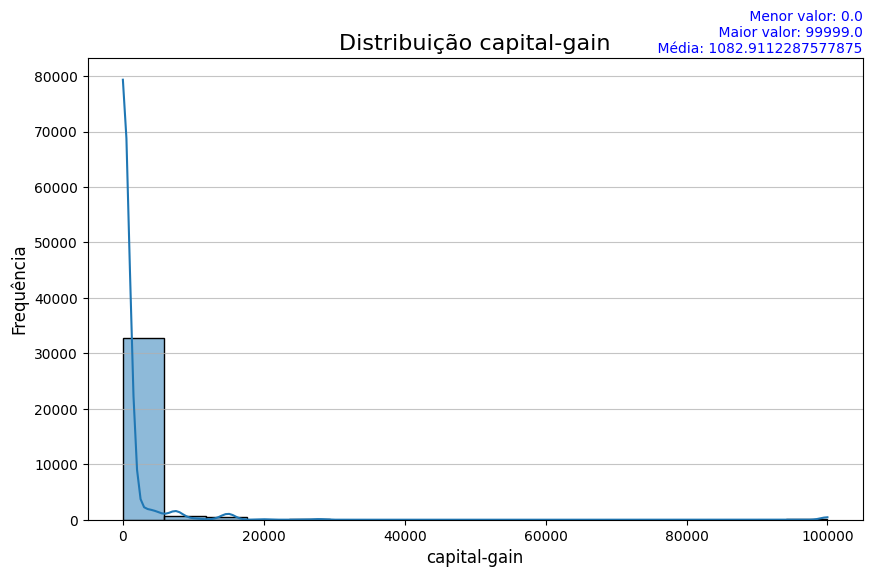

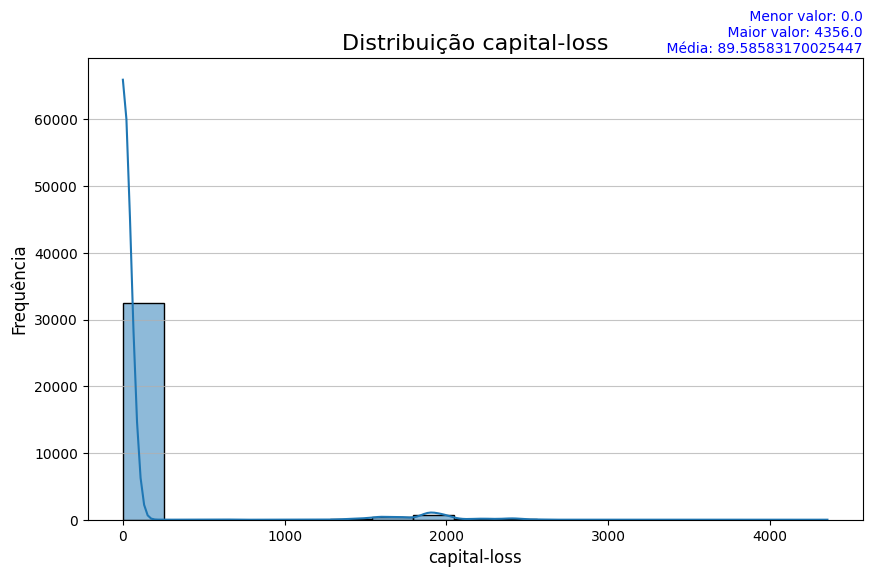

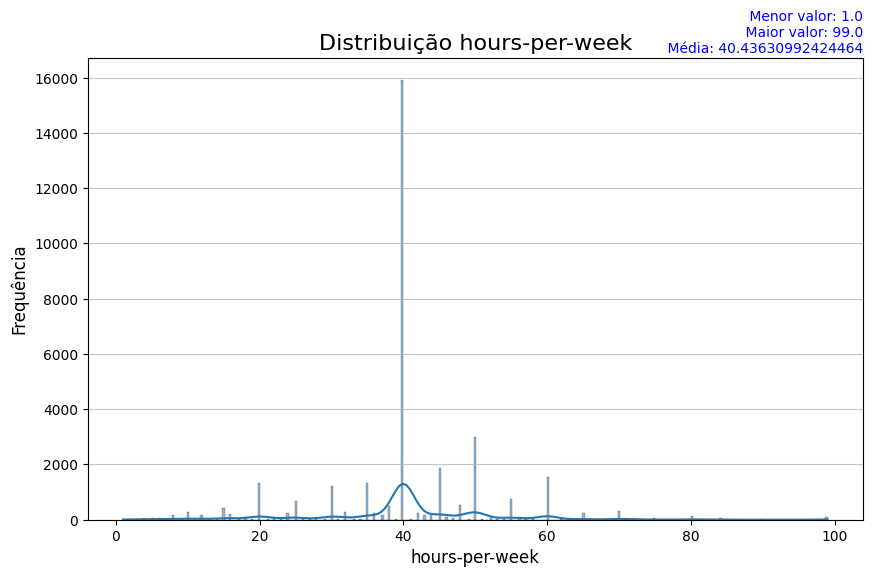

In [11]:
mostra_dados('float')

#Detecção de Anomalias com ZScore

Utilizarei o ZScore para os dados em que a média ficou muito discrepante dos valores mínimos e máximos dos dados.

Colunas: fnlwgt, capital-gain, capital-loss,

In [12]:
# Atribuindo os valores médios aos valores anômalos.
zscore_fnlwgt       = stats.zscore(treino['fnlwgt'])
anomalia_fnlwgt       = treino['fnlwgt'][np.abs(zscore_fnlwgt)>3.2]
print(len(anomalia_fnlwgt))
treino.loc[np.abs(zscore_fnlwgt) > 3.2, 'fnlwgt']               = int(treino['fnlwgt'].mean())

# zscore_gain      = stats.zscore(treino['capital-gain'])
# anomalia_gain       = treino['capital-gain'][np.abs(zscore_gain)>6]
# print(len(anomalia_gain))
# treino.loc[np.abs(zscore_gain) > 6, 'capital-gain']               = int(treino['capital-gain'].mean())

# zscore_loss       = stats.zscore(treino['capital-loss'])
# anomalia_loss       = treino['capital-loss'][np.abs(zscore_loss)>6]
# print(len(anomalia_loss))
# treino.loc[np.abs(zscore_loss) > 6, 'capital-loss']               = int(treino['capital-loss'].mean())


291


In [13]:
# Definindo a quantidade de linhas a serem dropadas
x_linhas_para_dropar = 16500 # Exemplo: dropar 16500 linhas aleatórias

# Filtrar o dataset para as linhas onde 'income' é '<=50K'
linhas_com_income_le50k = treino[treino['income'] == '<=50K'] # Assumindo que '0' representa '<=50K' após Label Encoding

# Verificar se há linhas suficientes para dropar

# Selecionar aleatoriamente 'x' índices dessas linhas
indices_para_dropar = linhas_com_income_le50k.sample(n=x_linhas_para_dropar, random_state=42).index

# Dropar as linhas selecionadas do dataset original
treino = treino.drop(indices_para_dropar)

print(f"Foram dropadas {x_linhas_para_dropar} linhas aleatórias com income <=50K.")
print(f"Novo formato do dataset de treino: {treino.shape}")

Foram dropadas 16500 linhas aleatórias com income <=50K.
Novo formato do dataset de treino: (17689, 15)


In [14]:
treino = padronizar_dataset(treino)
teste = padronizar_dataset(teste)
validacao = padronizar_dataset(validacao)
print(treino.shape)
print(teste.shape)
print(validacao.shape)

(17689, 16)
(7327, 16)
(7326, 16)


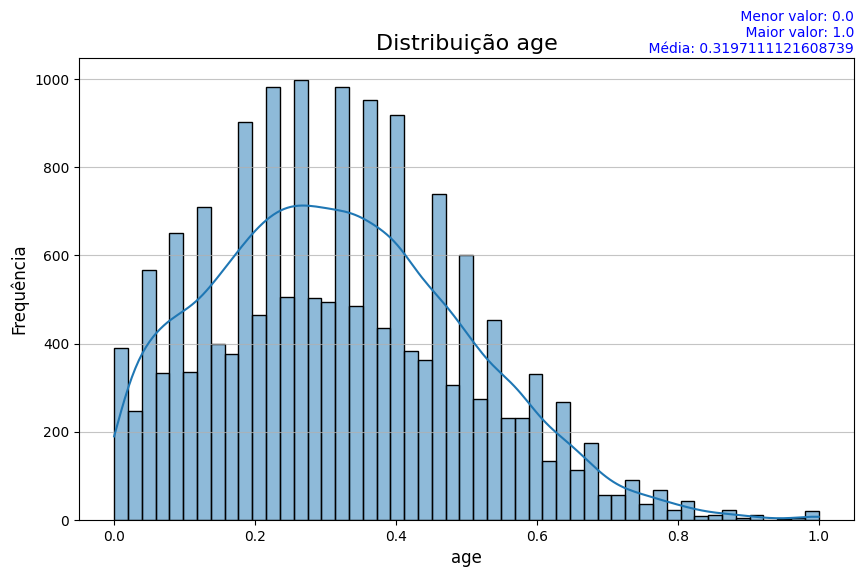

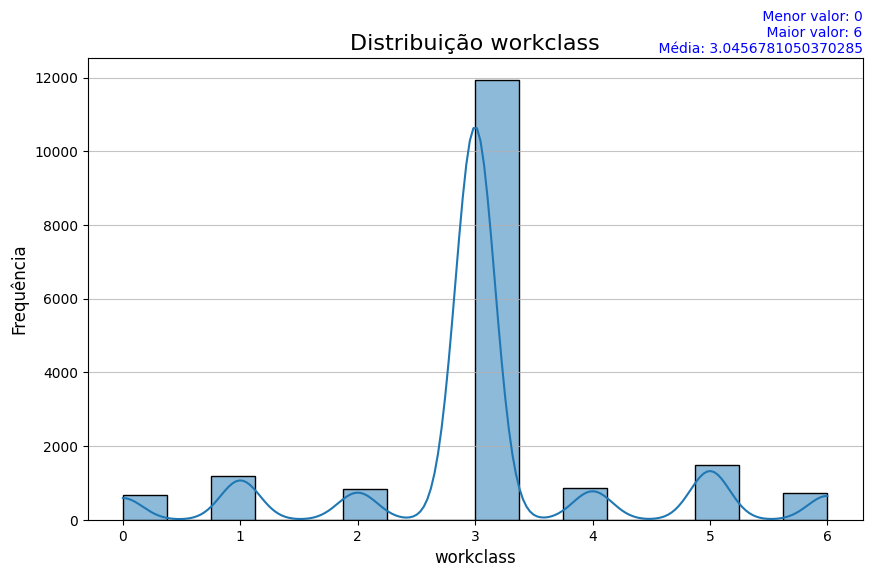

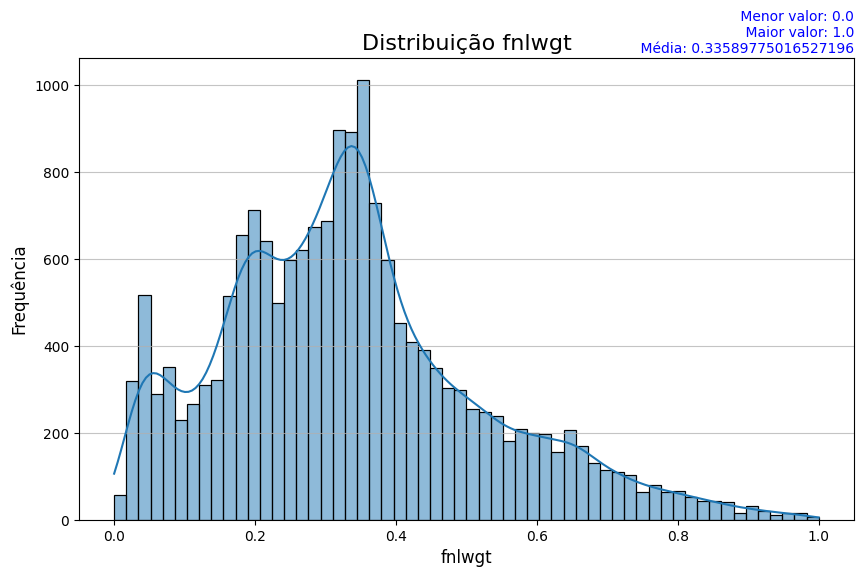

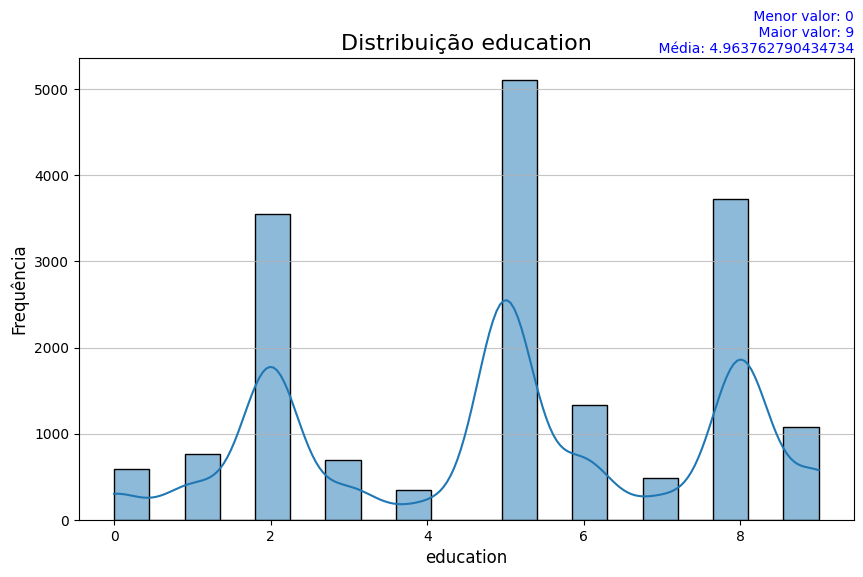

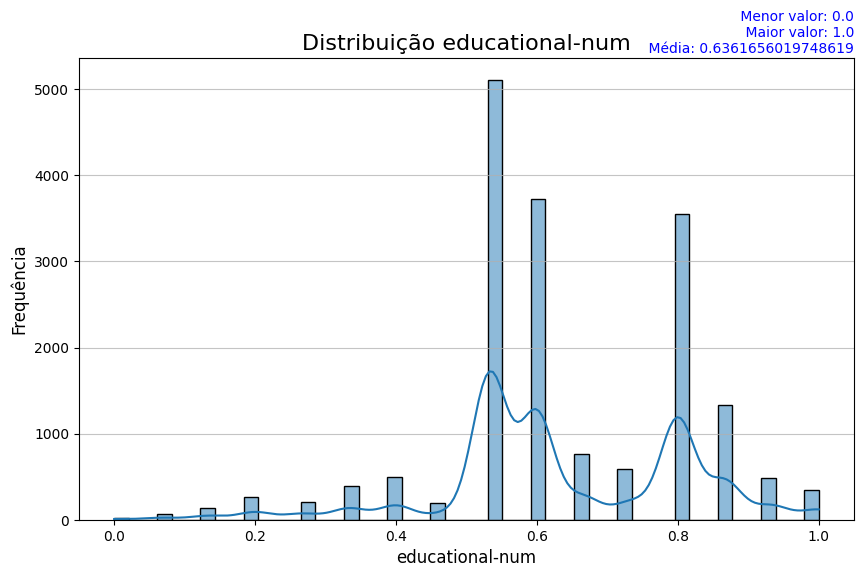

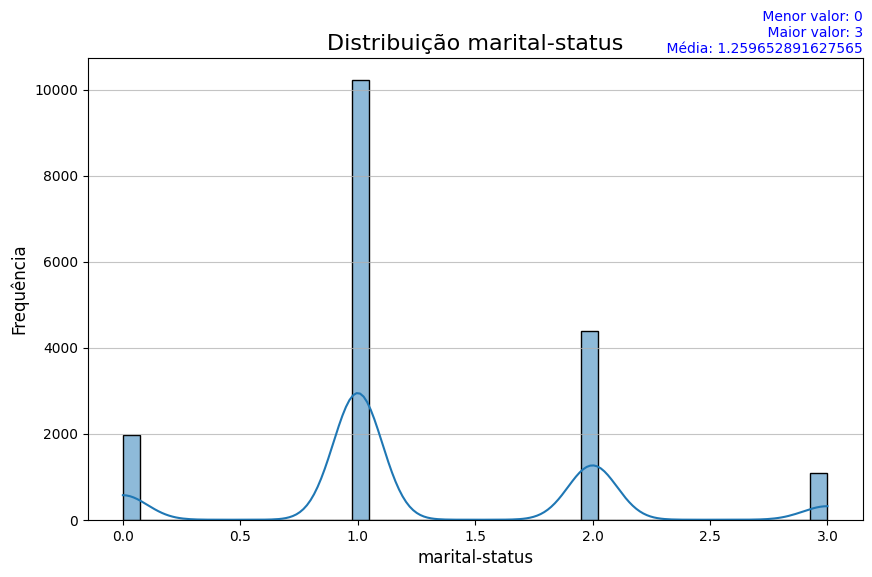

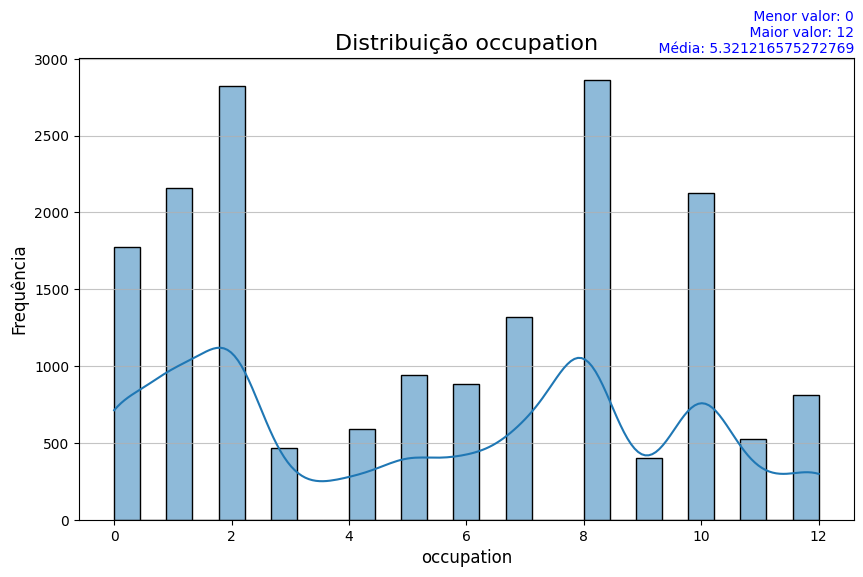

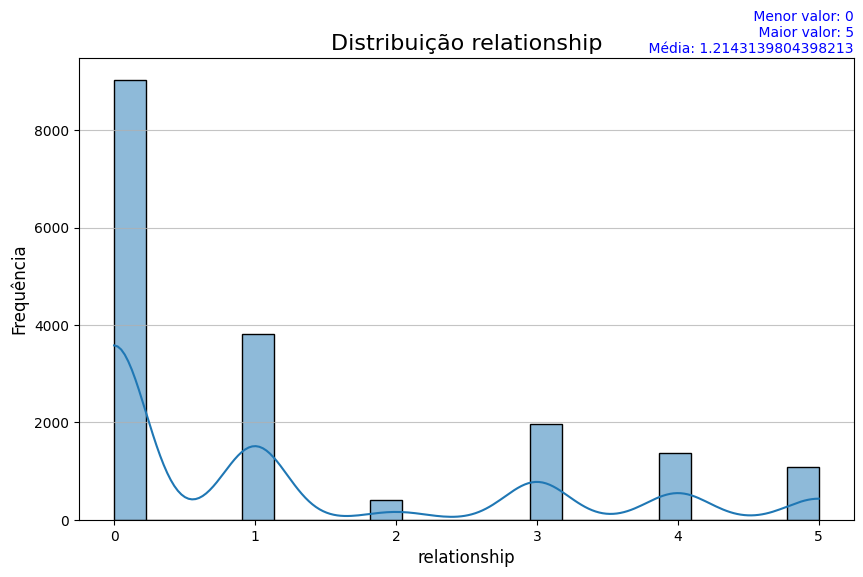

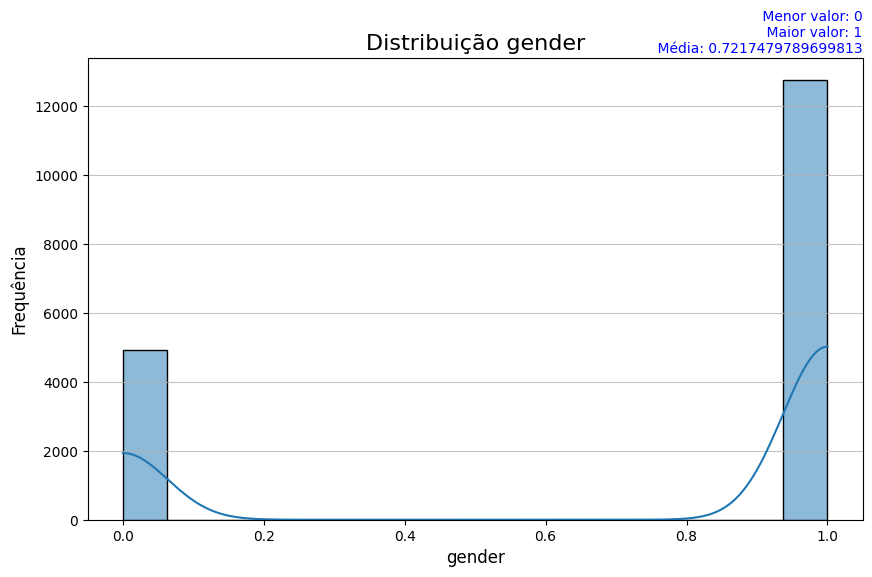

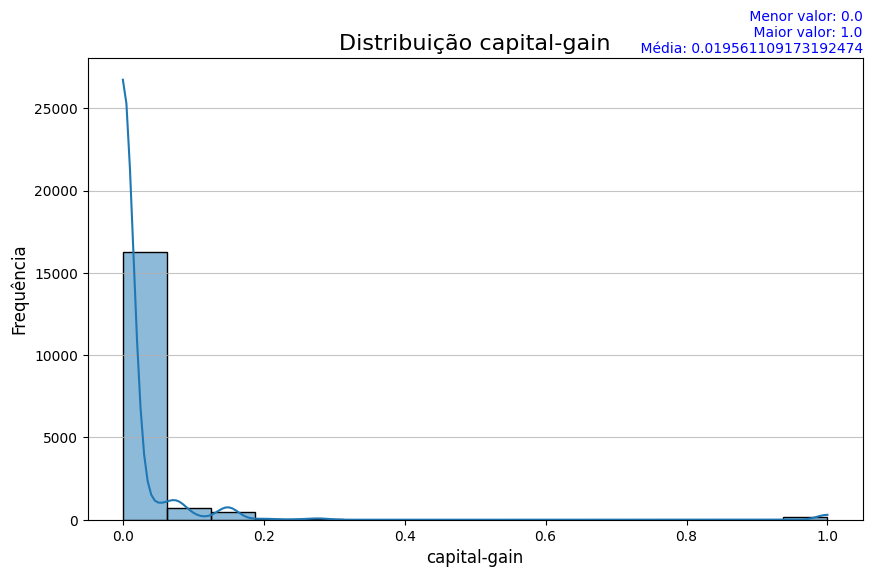

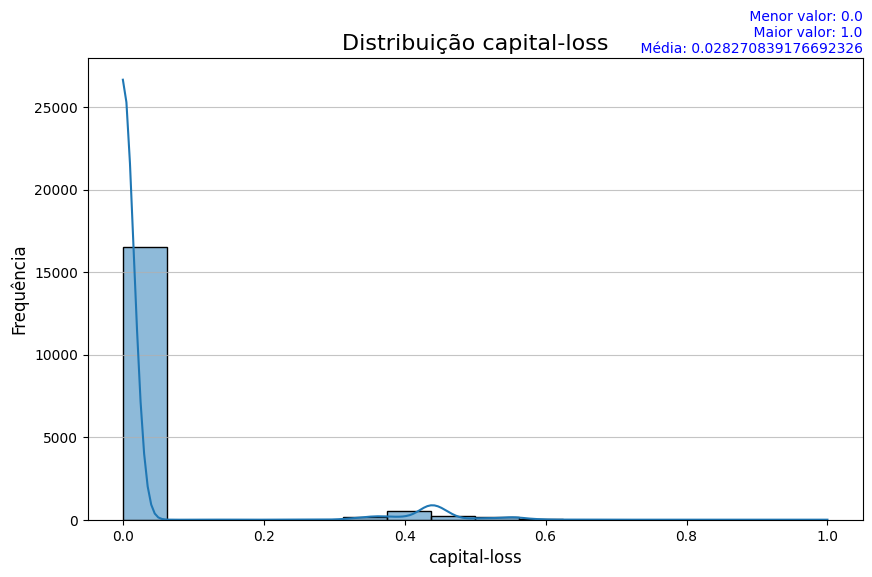

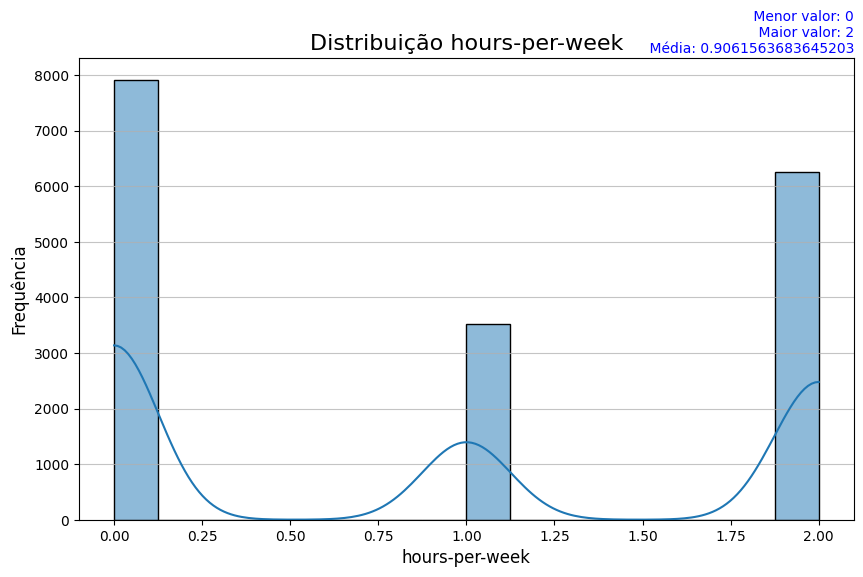

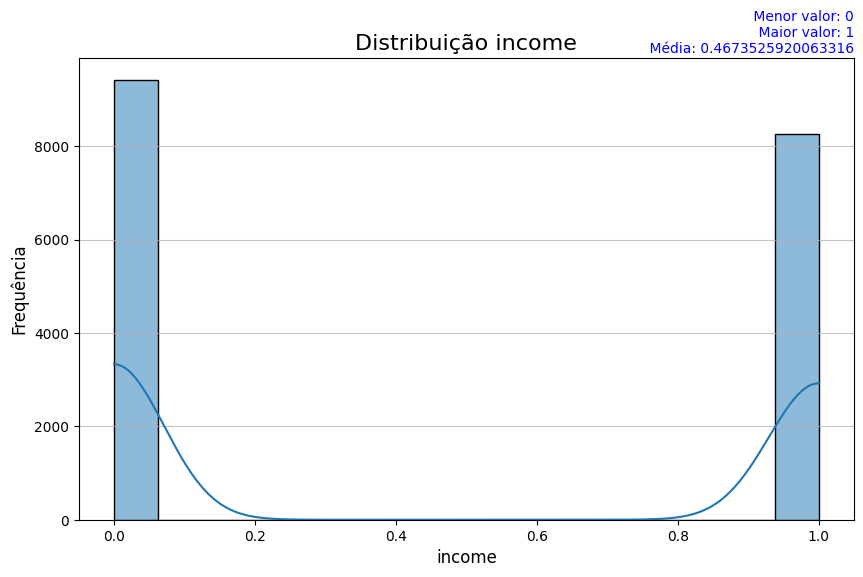

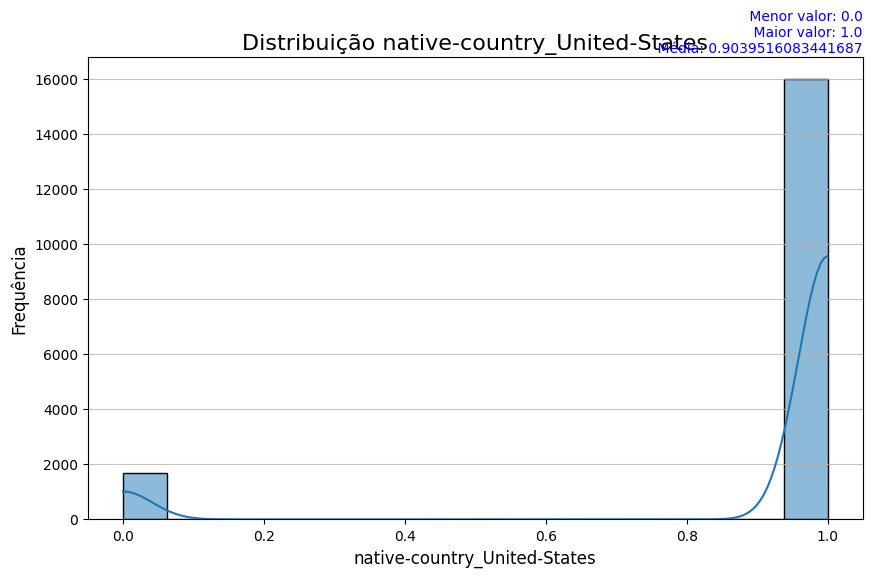

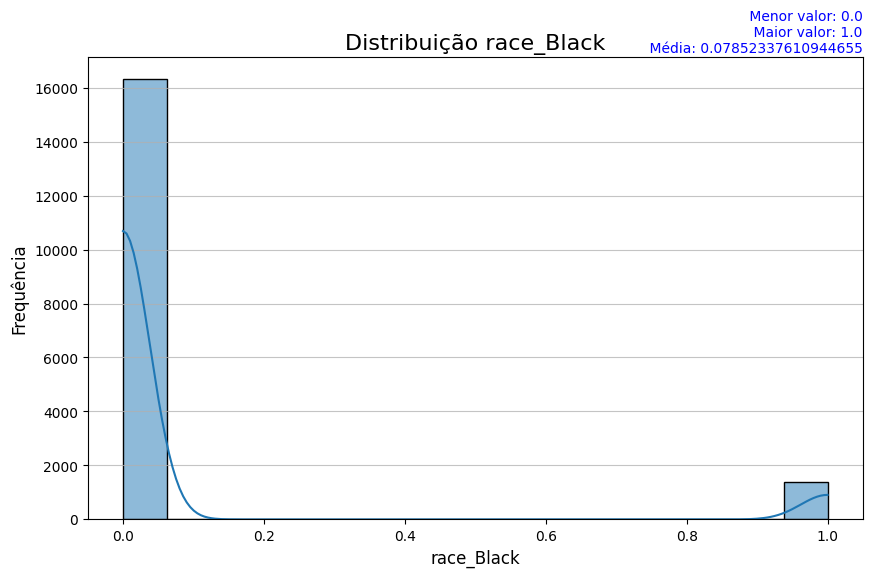

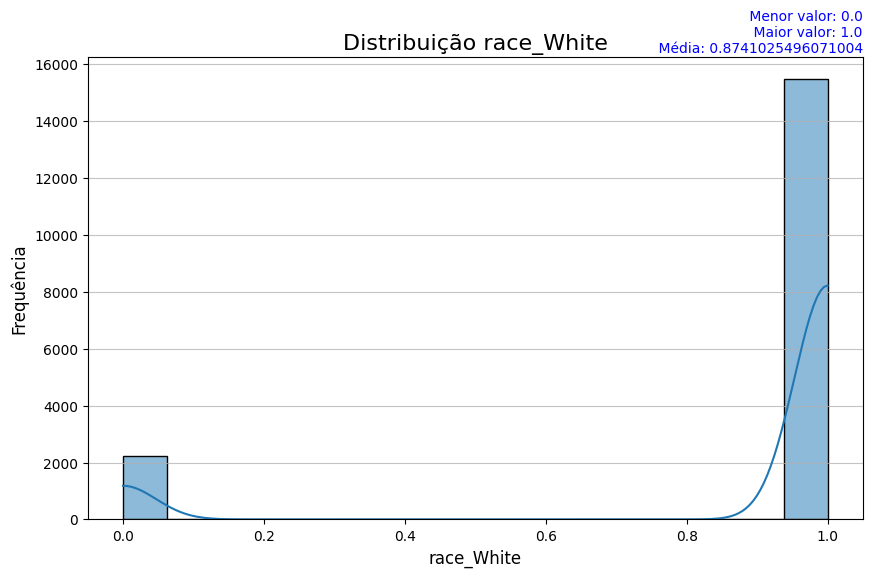

In [15]:
mostra_dados('float')

In [16]:
print(treino.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17689 entries, 0 to 17688
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           17689 non-null  float64
 1   workclass                     17689 non-null  int64  
 2   fnlwgt                        17689 non-null  float64
 3   education                     17689 non-null  int64  
 4   educational-num               17689 non-null  float64
 5   marital-status                17689 non-null  int64  
 6   occupation                    17689 non-null  int64  
 7   relationship                  17689 non-null  int64  
 8   gender                        17689 non-null  int64  
 9   capital-gain                  17689 non-null  float64
 10  capital-loss                  17689 non-null  float64
 11  hours-per-week                17689 non-null  int64  
 12  income                        17689 non-null  int64  
 13  n

Dados de treino e teste

In [17]:
treino_temp = treino.copy()
teste_temp = teste.copy()
validacao_temp = validacao.copy()

y_treino = treino_temp['income']
x_treino = treino_temp.drop('income', axis=1)

y_teste = teste_temp['income']
x_teste = teste_temp.drop('income', axis=1)

y_validacao = validacao_temp['income']
x_validacao = validacao_temp.drop('income', axis=1)

#Modelo

In [18]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_treino.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Saída binária (0 ou 1) para 'income'
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

print("Resumo do Modelo:")
model.summary()

Resumo do Modelo:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,209 (24.25 KB)

 Trainable params: 6,209 (24.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # métrica a ser monitorada (perda na validação)
    patience=10,         # número de épocas sem melhora antes de parar
    restore_best_weights=True, # restaura os pesos da melhor época
    mode='min'           # 'min' para monitorar métricas que devem diminuir (como perda)
)
model.fit(x_treino, y_treino, batch_size=35, epochs=100, validation_data=(x_validacao, y_validacao), callbacks=[early_stopping])

Epoch 1/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Precision: 0.5939 - Recall: 0.5949 - accuracy: 0.6203 - loss: 0.6553 - val_Precision: 0.4105 - val_Recall: 0.8242 - val_accuracy: 0.6876 - val_loss: 0.5554
Epoch 2/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.6979 - Recall: 0.7666 - accuracy: 0.7377 - loss: 0.5222 - val_Precision: 0.4497 - val_Recall: 0.8515 - val_accuracy: 0.7263 - val_loss: 0.4946
Epoch 3/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7284 - Recall: 0.7941 - accuracy: 0.7652 - loss: 0.4853 - val_Precision: 0.5206 - val_Recall: 0.7969 - val_accuracy: 0.7846 - val_loss: 0.4250
Epoch 4/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.7336 - Recall: 0.8023 - accuracy: 0.7722 - loss: 0.4690 - val_Precision: 0.4807 - val_Recall: 0.8729 - val_accuracy: 0.7540 - val_loss: 0.4438
Epoch 5/100
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7388 - Recall: 0.8181 - accuracy: 0.7802 - loss: 0.4554 - val_Precision: 0.5256 - val_Re

#AVALIACAO DO MODELO



In [20]:
y_pred_proba = model.predict(x_teste)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions (0 or 1)

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [21]:
accuracy = accuracy_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
conf_matrix = confusion_matrix(y_teste, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

Acurácia: 0.8331
F1-Score: 0.6937
Recall: 0.7978

Matriz de Confusão:
[[4719  872]
 [ 351 1385]]


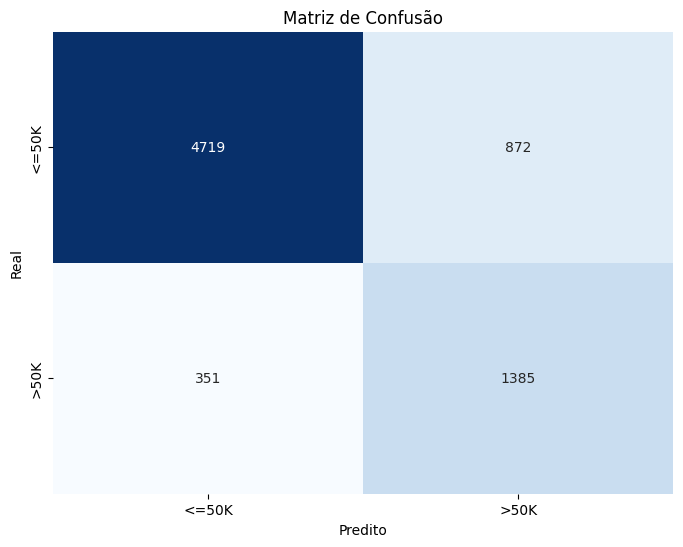

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

Primeiro teste:

  Matriz de Confusão:
  [[5321  270]
  [ 900  836]]

  -----------------

Segundo Teste: (Trocar os outliers pelo valor da moda ao invés da média)

  Matriz de Confusão:
  [[5318  273]
  [ 958  778]]

  -----------------

Terceiro Teste: (Sem tratamento de Outlier)

  Matriz de Confusão:
  [[5215  376]
  [ 699 1037]]

  -----------------

Quarto Teste: Tratamento de Outlier na coluna 'flwgt' + binning na coluna education + Remoção de 15k linhas de '<=50k' do income

  Matriz de Confusão:
  [[4719  872]
  [ 351 1385]]




In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados dos testes conforme fornecido
data = {
    'Teste': ['Primeiro Teste', 'Segundo Teste', 'Terceiro Teste', 'Quarto Teste'],
    'Acurácia': [0.8403, 0.8320, 0.8533, 0.8331],
    'F1-Score': [0.5883, 0.5583, 0.6586, 0.6937],
    'Recall': [0.4816, 0.4482, 0.5974, 0.7978]
}

df_comparacao = pd.DataFrame(data)

# Exibir o DataFrame de comparação
print("DataFrame de Comparação de Testes:")
display(df_comparacao)


DataFrame de Comparação de Testes:


,Teste,Acurácia,F1-Score,Recall
0,Primeiro Teste,0.8403,0.5883,0.4816
1,Segundo Teste,0.8320,0.5583,0.4482
2,Terceiro Teste,0.8533,0.6586,0.5974
3,Quarto Teste,0.8331,0.6937,0.7978


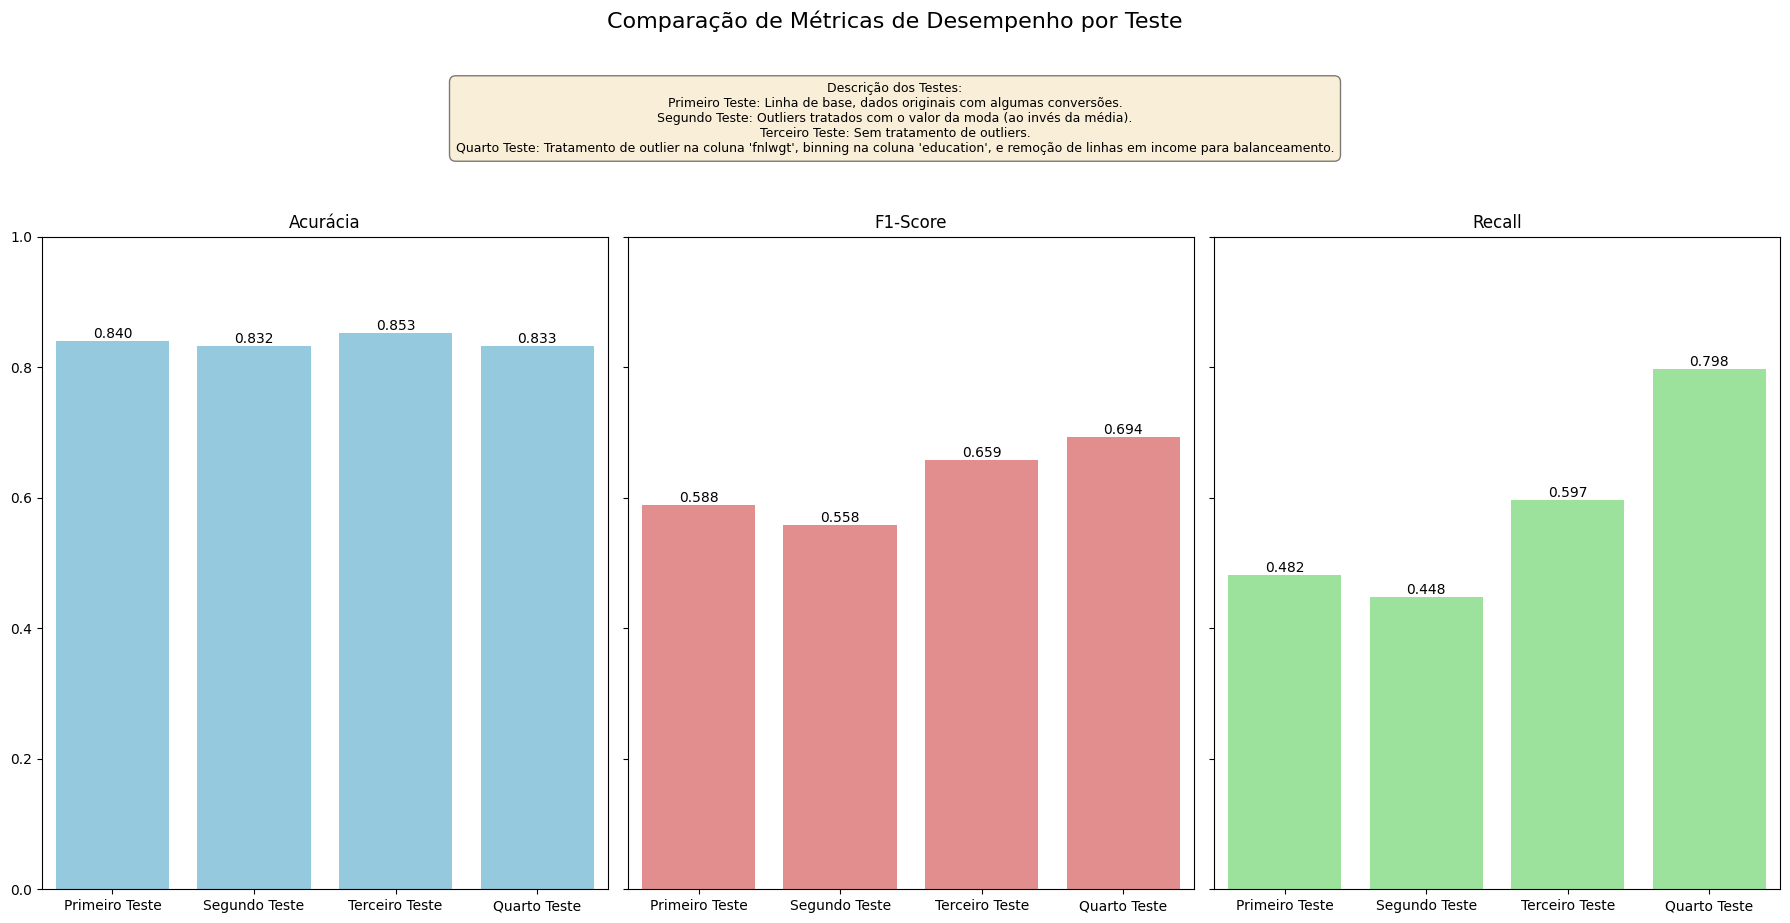

In [29]:
# Criar o gráfico de comparação
fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
fig.suptitle('Comparação de Métricas de Desempenho por Teste', fontsize=16, y=1.05)

metrics = ['Acurácia', 'F1-Score', 'Recall']
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Descrições detalhadas para cada teste
testes = """
Descrição dos Testes:
Primeiro Teste: Linha de base, dados originais com algumas conversões.
Segundo Teste: Outliers tratados com o valor da moda (ao invés da média).
Terceiro Teste: Sem tratamento de outliers.
Quarto Teste: Tratamento de outlier na coluna 'fnlwgt', binning na coluna 'education', e remoção de linhas em income para balanceamento.
"""

# Adicionar uma caixa de texto com as descrições acima dos subplots
fig.text(0.5, 0.97, testes.strip(),
         transform=fig.transFigure,
         fontsize=9,
         verticalalignment='top',
         horizontalalignment='center',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5),
         wrap=True)

for i, metric in enumerate(metrics):
    sns.barplot(x='Teste', y=metric, data=df_comparacao, ax=axes[i], color=colors[i])
    axes[i].set_title(metric)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_ylim(0, 1) # Limite para métricas de 0 a 1
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f')

plt.tight_layout(rect=[0, 0.03, 1, 0.88]) # Ajusta o layout para criar espaço para o texto e o título
plt.show()


#Avaliação final de performance

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Acurácia: 0.8179
F1-Score: 0.6599
Recall: 0.7684

Matriz de Confusão:
[[4698  944]
 [ 390 1294]]


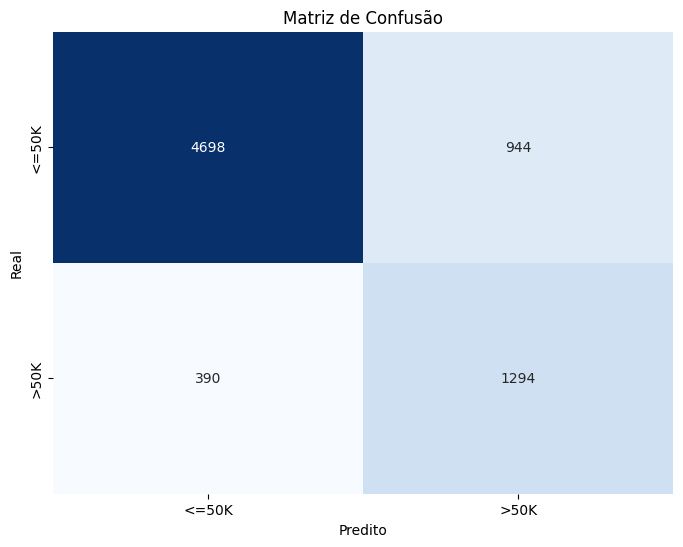

In [23]:
y_pred_proba = model.predict(x_validacao)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions (0 or 1)
accuracy = accuracy_score(y_validacao, y_pred)
f1 = f1_score(y_validacao, y_pred)
recall = recall_score(y_validacao, y_pred)
conf_matrix = confusion_matrix(y_validacao, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()